# Fox8-23 Dataset

**Hard facts:**
- Collection year: 2023
- Domain: General Twitter/X accounts
- Size: 2,280 accounts
- Labels: *bot* vs *human* (gold, manually verified)
- Features: account-level metadata, tweets, embeddings provided in the dataset

**Description:**
Fox8-23 was created at the Observatory on Social Media (OSoMe), Indiana University.
It addresses the rise of **LLM-powered bots** on social platforms. Unlike BotArtist, Fox8-23 contains **human-verified ground truth labels** for each account, ensuring reliable evaluation.

**Source:** [Zenodo](https://zenodo.org/record/10066202), [GitHub](https://github.com/osome-iu/AIBot_fox8)

Though smaller than BotArtist, this dataset is valuable for:
- Capturing **modern AI bot behaviors**.
- Serving as a **benchmark for fine-tuning** models pretrained on large, weakly labeled datasets.
- Providing **high-quality evaluation data** for bot detection systems.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pprint import pprint
from sklearn.model_selection import train_test_split

In [2]:
import importlib
from utils import data_prepping
importlib.reload(data_prepping)

from utils.data_prepping import plot_threshold, evaluate_model, plot_confusion

## Data Loading

In [3]:
path = "data/2_Fox8-23/fox8_23_dataset.ndjson.gz"
df = pd.read_json(path, lines=True, compression="gzip")


In [4]:
original = df.copy()

In [5]:
print("Shape of dataset:", df.shape)
df.head()

Shape of dataset: (2280, 4)


,user_id,label,dataset,user_tweets
0,16905397,human,botometer-feedback,"[{'contributors': None, 'truncated': True, 'te..."
1,2717053344,human,botometer-feedback,"[{'contributors': None, 'truncated': False, 't..."
2,297051227,human,botometer-feedback,"[{'contributors': None, 'truncated': False, 't..."
3,282275320,human,botometer-feedback,"[{'contributors': None, 'truncated': False, 't..."
4,1663020151,human,botometer-feedback,"[{'contributors': None, 'truncated': False, 't..."


In [6]:
print(df.columns)

Index(['user_id', 'label', 'dataset', 'user_tweets'], dtype='object')


In [7]:
row_idx = 10  # index of row
tweets_list = df.at[row_idx, 'user_tweets']

print(f"Inspecting row {row_idx} | user_id={df.at[row_idx,'user_id']} | label={df.at[row_idx,'label']}")
print(f"Number of tweets in this list: {len(tweets_list)}\n")

# 2) Show the first tweet dict, pretty
print("First tweet dict (pretty):")
pprint(tweets_list[0], width=100)
print("--------"*18)
# 3) Show just the top-level keys to understand the fields available
print("\nKeys in first tweet:", list(tweets_list[0].keys()))

# 4) (Optional) Union of keys across the first N tweets to see variability
N = min(10, len(tweets_list))
keys_union = set().union(*[t.keys() for t in tweets_list[:N]])
print(f"\nUnion of keys across first {N} tweets:", sorted(keys_union))

# 5) (Optional) Turn that tweet list into a small flat dataframe view
flat = pd.json_normalize(tweets_list, sep='.')
display(flat.head(2))


Inspecting row 10 | user_id=804681 | label=human
Number of tweets in this list: 200

First tweet dict (pretty):
{'contributors': None,
 'coordinates': None,
 'created_at': 'Mon Apr 16 21:51:55 +0000 2018',
 'entities': {'hashtags': [],
              'symbols': [],
              'urls': [{'display_url': 'twitter.com/i/web/status/9…',
                        'expanded_url': 'https://twitter.com/i/web/status/985999253595140097',
                        'indices': [117, 140],
                        'url': 'https://t.co/IaLKn3dkK4'}],
              'user_mentions': [{'id': 20793816,
                                 'id_str': '20793816',
                                 'indices': [3, 10],
                                 'name': 'Amazon.com',
                                 'screen_name': 'amazon'}]},
 'favorite_count': 1,
 'favorited': False,
 'geo': None,
 'id': 985999253595140097,
 'id_str': '985999253595140097',
 'in_reply_to_screen_name': None,
 'in_reply_to_status_id': None,
 'in_re

,contributors,truncated,text,is_quote_status,in_reply_to_status_id,id,favorite_count,source,retweeted,coordinates,...,retweeted_status.quoted_status.in_reply_to_user_id_str,retweeted_status.quoted_status.possibly_sensitive,retweeted_status.quoted_status.lang,retweeted_status.quoted_status.created_at,retweeted_status.quoted_status.in_reply_to_status_id_str,retweeted_status.quoted_status.place,retweeted_status.quoted_status.extended_entities.media,retweeted_status.quoted_status_id_str,quoted_status.entities.media,quoted_status.extended_entities.media
0,None,True,"Yo @amazon, why don't you start using reusable...",False,NaN,985999253595140097,1,"<a href=""http://www.hootsuite.com"" rel=""nofoll...",False,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,None,True,"PSA: Beware of advice from the ""guru"", self-he...",False,NaN,984191467014049794,1,"<a href=""http://www.hootsuite.com"" rel=""nofoll...",False,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## EDA

Label counts:
label
human    1140
bot      1140
Name: count, dtype: int64

Label proportions:
label
human    0.5
bot      0.5
Name: proportion, dtype: float64


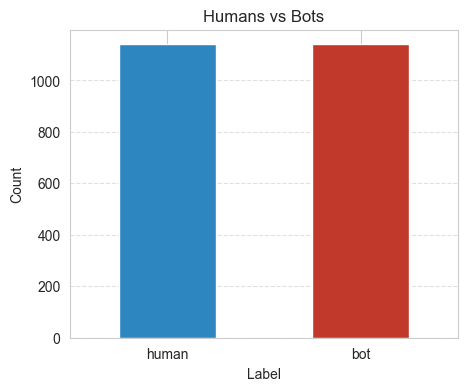

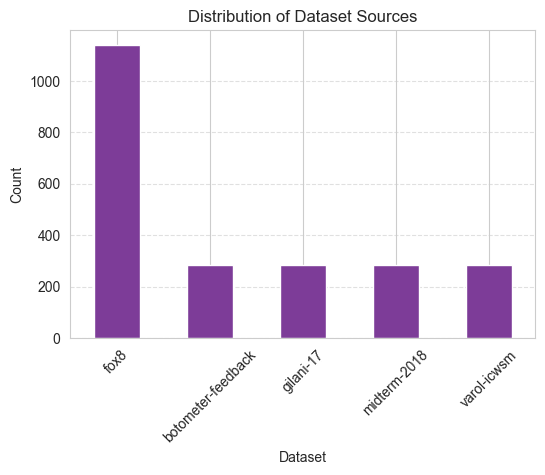

In [8]:
# --- 1. Label distribution ---
print("Label counts:")
print(df['label'].value_counts())
print("\nLabel proportions:")
print(df['label'].value_counts(normalize=True))

plt.figure(figsize=(5,4))
df['label'].value_counts().plot(kind='bar', rot=0, color=['#2E86C1', '#C0392B'])
plt.title('Humans vs Bots')
plt.xlabel('Label')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# --- 2. Dataset composition ---
plt.figure(figsize=(6,4))
df['dataset'].value_counts().plot(kind='bar', rot=45, color='#7D3C98')
plt.title('Distribution of Dataset Sources')
plt.xlabel('Dataset')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


Number of tweets per user — summary stats:
count    2280.000000
mean      161.415789
std        49.700992
min         1.000000
25%       123.000000
50%       195.000000
75%       200.000000
90%       200.000000
95%       200.000000
99%       200.000000
max       211.000000
Name: number_of_tweets, dtype: float64


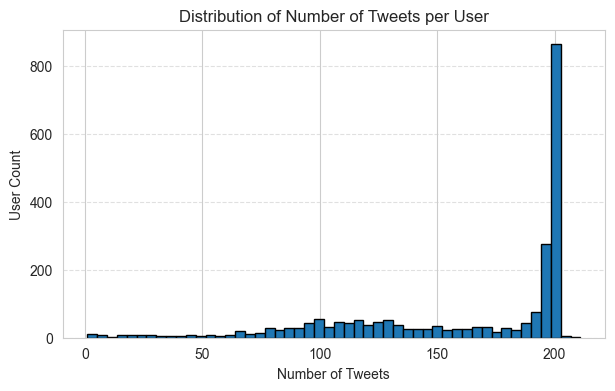

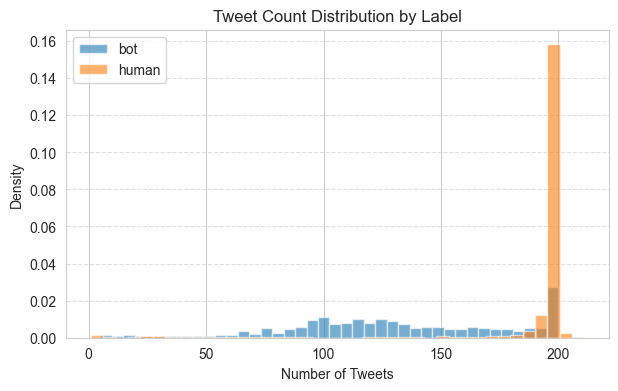

In [9]:
# --- 1. Add number_of_tweets column ---
df['number_of_tweets'] = df['user_tweets'].apply(lambda x: len(x) if isinstance(x, list) else 0)

print("Number of tweets per user — summary stats:")
print(df['number_of_tweets'].describe(percentiles=[.25, .5, .75, .9, .95, .99]))

# --- 2. Plot histogram ---
plt.figure(figsize=(7,4))
df['number_of_tweets'].hist(bins=50, color='#1F77B4', edgecolor='black')
plt.title('Distribution of Number of Tweets per User')
plt.xlabel('Number of Tweets')
plt.ylabel('User Count')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# --- 3. Compare by label (humans vs bots) ---
plt.figure(figsize=(7,4))
df.groupby('label')['number_of_tweets'].plot(
    kind='hist',
    bins=40,
    alpha=0.6,
    legend=True,
    density=True
)
plt.title('Tweet Count Distribution by Label')
plt.xlabel('Number of Tweets')
plt.ylabel('Density')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

In [10]:
df.head(5)

,user_id,label,dataset,user_tweets,number_of_tweets
0,16905397,human,botometer-feedback,"[{'contributors': None, 'truncated': True, 'te...",200
1,2717053344,human,botometer-feedback,"[{'contributors': None, 'truncated': False, 't...",197
2,297051227,human,botometer-feedback,"[{'contributors': None, 'truncated': False, 't...",200
3,282275320,human,botometer-feedback,"[{'contributors': None, 'truncated': False, 't...",200
4,1663020151,human,botometer-feedback,"[{'contributors': None, 'truncated': False, 't...",199


In [11]:
UTC_NOW = pd.Timestamp.now(tz="UTC")
_FAST_FORMATS = ["%Y-%m-%dT%H:%M:%S.%fZ", "%Y-%m-%dT%H:%M:%SZ"]

def _parse_iso_fast(s: str):
    for fmt in _FAST_FORMATS:
        try:  # try exact ISO formats first (fast + quiet)
            return pd.to_datetime(s, format=fmt, utc=True)
        except Exception:
            pass
    return pd.to_datetime(s, errors="coerce", utc=True)  # generic safe fallback

def parse_created_at(val):
    """Return tz-aware UTC Timestamp or NaT from mixed formats (ISO/epoch)."""
    if val is None:
        return pd.NaT
    if isinstance(val, (int, float)):  # epoch seconds/millis
        if val > 1e12:
            return pd.to_datetime(val, unit="ms", utc=True, errors="coerce")
        if val > 1e9:
            return pd.to_datetime(val, unit="s",  utc=True, errors="coerce")
        return pd.NaT
    if isinstance(val, str):
        return _parse_iso_fast(val)
    return pd.NaT

# ---- single parser for one user's tweets ----
def parse_user_tweets(tweet_list):
    """
    Input: list[dict] (tweets for a user)
    Output: pd.Series with parsed signals (no plotting)
    """
    if not isinstance(tweet_list, list) or len(tweet_list) == 0:
        return pd.Series({
            "number_of_tweets": 0,
            "first_tweet_date": pd.NaT,
            "last_tweet_date":  pd.NaT,
            "account_age_days": np.nan,
            "span_days": 0.0,
            "tweets_per_day": 0.0,
            "avg_len": 0.0,
            "median_len": 0.0,
            "frac_has_url": 0.0,
            "frac_has_hashtag": 0.0,
            "frac_has_mention": 0.0,
            "frac_retweet": 0.0,
            "frac_reply": 0.0,
        })

# dates (tz-aware)----------------------
    dts = [parse_created_at(t.get("created_at")) for t in tweet_list if isinstance(t, dict)]
    dts = [d for d in dts if pd.notna(d)]

    if len(dts):
        first_dt = min(dts)
        last_dt  = max(dts)
        age_days = float((UTC_NOW - first_dt).total_seconds() / 86400.0)
        span_days = float((last_dt - first_dt).total_seconds() / 86400.0)
        if span_days <= 0:
            span_days = 1.0  # avoid div-by-zero
    else:
        first_dt = last_dt = pd.NaT
        age_days = np.nan
        span_days = 1.0

    n = len(tweet_list)
    tweets_per_day = n / span_days if span_days > 0 else 0.0

# text lengths---------------------------
    texts = [str(t.get("text", "")) for t in tweet_list if isinstance(t, dict)]
    lens = np.array([len(s) for s in texts], dtype=float) if texts else np.array([0.0])
    avg_len = float(lens.mean()) if lens.size else 0.0
    median_len = float(np.median(lens)) if lens.size else 0.0


# simple flags---------------------------
    has_url     = [bool((t.get("entities", {}) or {}).get("urls")) or ("http" in str(t.get("text",""))) for t in tweet_list]
    has_hashtag = [bool((t.get("entities", {}) or {}).get("hashtags")) or ("#" in str(t.get("text",""))) for t in tweet_list]
    has_mention = [bool((t.get("entities", {}) or {}).get("mentions")) or ("@" in str(t.get("text",""))) for t in tweet_list]
    is_retweet  = [ (isinstance(t.get("referenced_tweets"), list) and len(t["referenced_tweets"])>0 and t["referenced_tweets"][0].get("type")=="retweeted") for t in tweet_list ]
    is_reply    = [ t.get("in_reply_to_user_id") is not None for t in tweet_list ]

    frac = lambda arr: float(np.mean(arr)) if len(arr) else 0.0

    return pd.Series({
        "number_of_tweets": n,
        "first_tweet_date": first_dt,
        "last_tweet_date":  last_dt,
        "account_age_days": age_days,
        "span_days": span_days,
        "tweets_per_day": tweets_per_day,
        "avg_len": avg_len,
        "median_len": median_len,
        "frac_has_url": frac(has_url),
        "frac_has_hashtag": frac(has_hashtag),
        "frac_has_mention": frac(has_mention),
        "frac_retweet": frac(is_retweet),
        "frac_reply": frac(is_reply),
    })

# ----
#df = original.copy()
parsed = df["user_tweets"].apply(parse_user_tweets)
df = pd.concat([df, parsed], axis=1)

df.head(3)


,user_id,label,dataset,user_tweets,number_of_tweets,number_of_tweets,first_tweet_date,last_tweet_date,account_age_days,span_days,tweets_per_day,avg_len,median_len,frac_has_url,frac_has_hashtag,frac_has_mention,frac_retweet,frac_reply
0,16905397,human,botometer-feedback,"[{'contributors': None, 'truncated': True, 'te...",200,200,2018-04-10 18:45:00+00:00,2018-04-18 14:09:01+00:00,2758.612868,7.808345,25.613623,122.445000,139.0,0.455000,0.675000,0.700000,0.0,0.165000
1,2717053344,human,botometer-feedback,"[{'contributors': None, 'truncated': False, 't...",197,197,2015-04-01 18:26:50+00:00,2018-04-01 18:09:12+00:00,3863.625483,1095.987755,0.179747,94.507614,90.0,0.380711,0.294416,0.939086,0.0,0.461929
2,297051227,human,botometer-feedback,"[{'contributors': None, 'truncated': False, 't...",200,200,2015-09-28 09:26:28+00:00,2018-04-15 22:14:37+00:00,3684.000738,930.533437,0.214930,116.360000,129.5,0.730000,0.145000,0.750000,0.0,0.210000


In [12]:
df.columns

Index(['user_id', 'label', 'dataset', 'user_tweets', 'number_of_tweets',
       'number_of_tweets', 'first_tweet_date', 'last_tweet_date',
       'account_age_days', 'span_days', 'tweets_per_day', 'avg_len',
       'median_len', 'frac_has_url', 'frac_has_hashtag', 'frac_has_mention',
       'frac_retweet', 'frac_reply'],
      dtype='object')

In [13]:
df[["number_of_tweets","span_days","tweets_per_day"]].head()

,number_of_tweets,number_of_tweets,span_days,tweets_per_day
0,200,200,7.808345,25.613623
1,197,197,1095.987755,0.179747
2,200,200,930.533437,0.214930
3,200,200,2.232431,89.588453
4,199,199,4.287847,46.410236


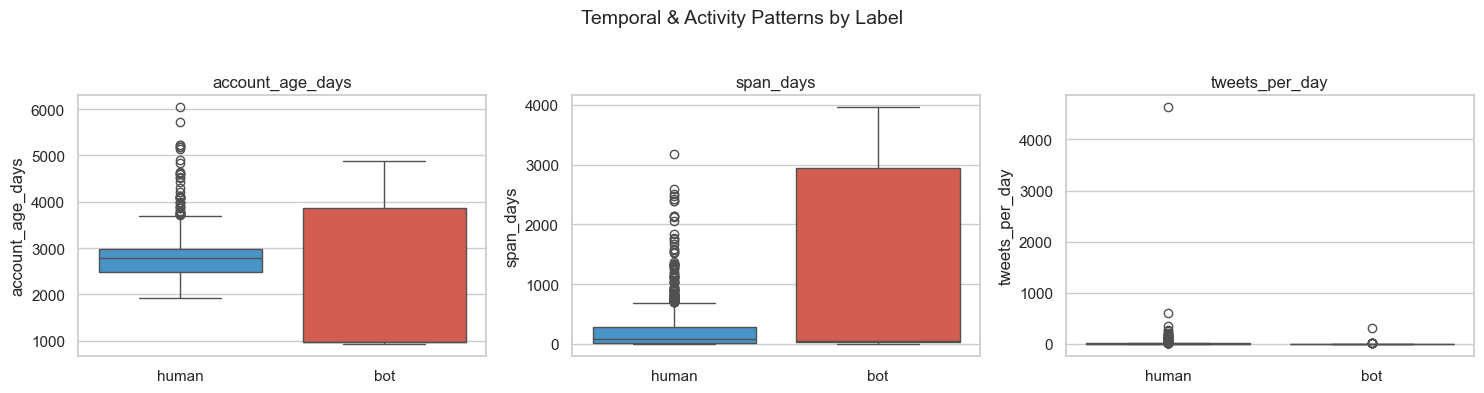

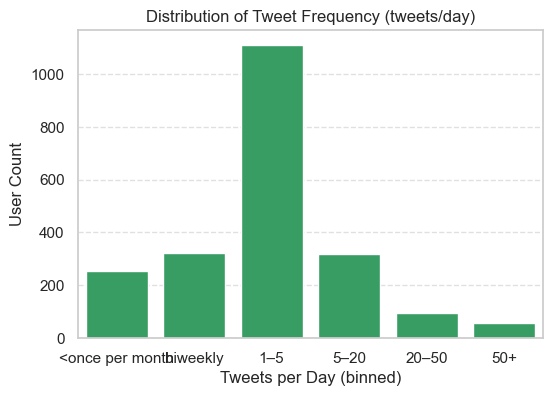

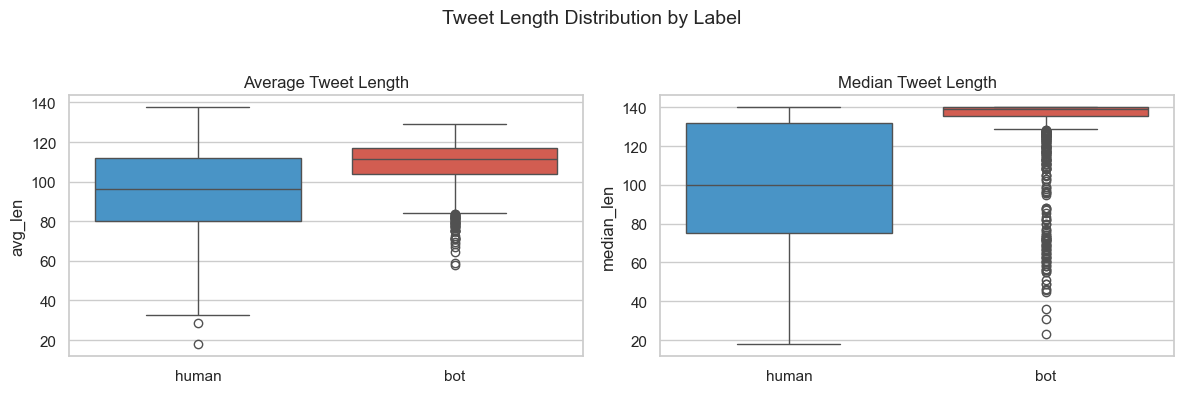

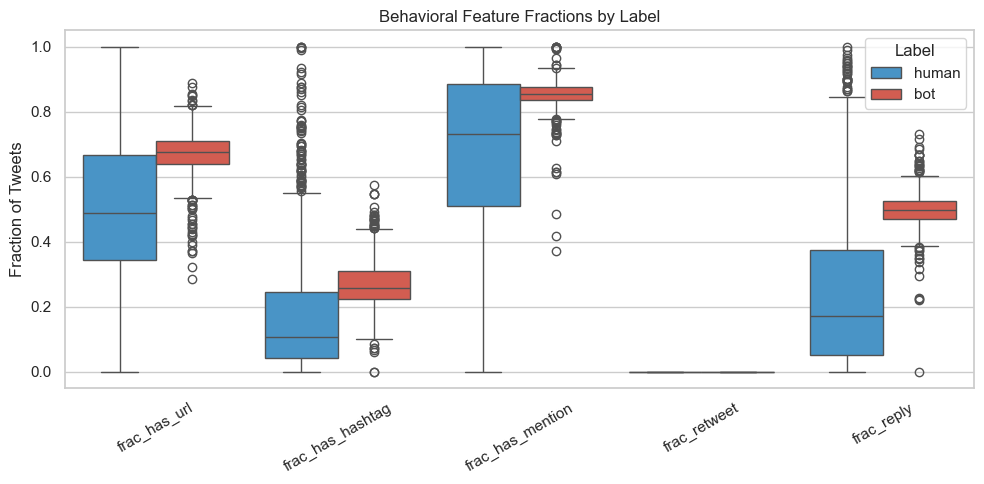

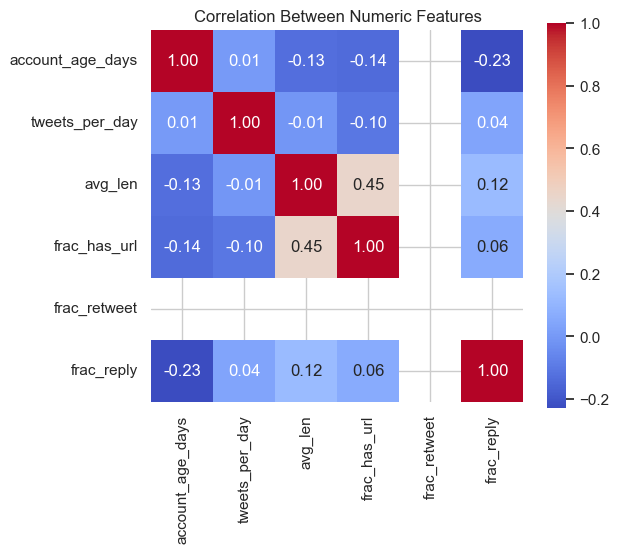

In [14]:
df = df.loc[:, ~df.columns.duplicated()]

sns.set(style="whitegrid", context="notebook")
palette = {"bot": "#E74C3C", "human": "#3498DB"}

# --- 1. Temporal / activity features ---
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, col in zip(axes, ["account_age_days", "span_days", "tweets_per_day"]):
    sns.boxplot(data=df, x="label", y=col, hue="label", palette=palette, ax=ax)
    ax.set_title(col)
    ax.set_xlabel("")
plt.suptitle("Temporal & Activity Patterns by Label", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

#Bins
bins = [0.03, 0.15, 1, 5, 20, 50, df["tweets_per_day"].max()]
labels = ["<once per month", "biweekly", "1–5", "5–20", "20–50", "50+"]

df["tweets_per_day_bin"] = pd.cut(df["tweets_per_day"], bins=bins, labels=labels, include_lowest=True, right=False)

# Plot
plt.figure(figsize=(6,4))
sns.countplot(x="tweets_per_day_bin", data=df, color="#27AE60")
plt.title("Distribution of Tweet Frequency (tweets/day)")
plt.xlabel("Tweets per Day (binned)")
plt.ylabel("User Count")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

# --- 2. Content features ---
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.boxplot(data=df, x="label", y="avg_len", hue="label", palette=palette, ax=axes[0])
sns.boxplot(data=df, x="label", y="median_len", hue="label", palette=palette, ax=axes[1])
axes[0].set_title("Average Tweet Length")
axes[1].set_title("Median Tweet Length")
for ax in axes: ax.set_xlabel("")
plt.suptitle("Tweet Length Distribution by Label", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# --- 3. Behavioral indicators ---
behavior_cols = ["frac_has_url", "frac_has_hashtag", "frac_has_mention", "frac_retweet", "frac_reply"]
plt.figure(figsize=(10,5))
df_melt = df.melt(id_vars="label", value_vars=behavior_cols, var_name="feature", value_name="fraction")
sns.boxplot(data=df_melt, x="feature", y="fraction", hue="label", palette=palette)
plt.xticks(rotation=30)
plt.title("Behavioral Feature Fractions by Label")
plt.ylabel("Fraction of Tweets")
plt.xlabel("")
plt.legend(title="Label")
plt.tight_layout()
plt.show()

# --- 4. Correlation heatmap (bots + humans combined) ---
cols_for_corr = ["account_age_days","tweets_per_day","avg_len","frac_has_url","frac_retweet","frac_reply"]
corr = df[cols_for_corr].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlation Between Numeric Features")
plt.show()


## Preprocessing

In [15]:
df.head()

,user_id,label,dataset,user_tweets,number_of_tweets,first_tweet_date,last_tweet_date,account_age_days,span_days,tweets_per_day,avg_len,median_len,frac_has_url,frac_has_hashtag,frac_has_mention,frac_retweet,frac_reply,tweets_per_day_bin
0,16905397,human,botometer-feedback,"[{'contributors': None, 'truncated': True, 'te...",200,2018-04-10 18:45:00+00:00,2018-04-18 14:09:01+00:00,2758.612868,7.808345,25.613623,122.445000,139.0,0.455000,0.675000,0.700000,0.0,0.165000,20–50
1,2717053344,human,botometer-feedback,"[{'contributors': None, 'truncated': False, 't...",197,2015-04-01 18:26:50+00:00,2018-04-01 18:09:12+00:00,3863.625483,1095.987755,0.179747,94.507614,90.0,0.380711,0.294416,0.939086,0.0,0.461929,biweekly
2,297051227,human,botometer-feedback,"[{'contributors': None, 'truncated': False, 't...",200,2015-09-28 09:26:28+00:00,2018-04-15 22:14:37+00:00,3684.000738,930.533437,0.214930,116.360000,129.5,0.730000,0.145000,0.750000,0.0,0.210000,biweekly
3,282275320,human,botometer-feedback,"[{'contributors': None, 'truncated': False, 't...",200,2018-04-15 23:47:16+00:00,2018-04-18 05:21:58+00:00,2753.402960,2.232431,89.588453,109.360000,122.0,0.585000,0.225000,0.910000,0.0,0.170000,50+
4,1663020151,human,botometer-feedback,"[{'contributors': None, 'truncated': False, 't...",199,2018-04-13 20:57:28+00:00,2018-04-18 03:51:58+00:00,2755.520877,4.287847,46.410236,98.075377,109.0,0.316583,0.025126,0.889447,0.0,0.477387,20–50


In [16]:
df = df.drop(columns=["tweets_per_day_bin"])
df.head(5)


,user_id,label,dataset,user_tweets,number_of_tweets,first_tweet_date,last_tweet_date,account_age_days,span_days,tweets_per_day,avg_len,median_len,frac_has_url,frac_has_hashtag,frac_has_mention,frac_retweet,frac_reply
0,16905397,human,botometer-feedback,"[{'contributors': None, 'truncated': True, 'te...",200,2018-04-10 18:45:00+00:00,2018-04-18 14:09:01+00:00,2758.612868,7.808345,25.613623,122.445000,139.0,0.455000,0.675000,0.700000,0.0,0.165000
1,2717053344,human,botometer-feedback,"[{'contributors': None, 'truncated': False, 't...",197,2015-04-01 18:26:50+00:00,2018-04-01 18:09:12+00:00,3863.625483,1095.987755,0.179747,94.507614,90.0,0.380711,0.294416,0.939086,0.0,0.461929
2,297051227,human,botometer-feedback,"[{'contributors': None, 'truncated': False, 't...",200,2015-09-28 09:26:28+00:00,2018-04-15 22:14:37+00:00,3684.000738,930.533437,0.214930,116.360000,129.5,0.730000,0.145000,0.750000,0.0,0.210000
3,282275320,human,botometer-feedback,"[{'contributors': None, 'truncated': False, 't...",200,2018-04-15 23:47:16+00:00,2018-04-18 05:21:58+00:00,2753.402960,2.232431,89.588453,109.360000,122.0,0.585000,0.225000,0.910000,0.0,0.170000
4,1663020151,human,botometer-feedback,"[{'contributors': None, 'truncated': False, 't...",199,2018-04-13 20:57:28+00:00,2018-04-18 03:51:58+00:00,2755.520877,4.287847,46.410236,98.075377,109.0,0.316583,0.025126,0.889447,0.0,0.477387


In [17]:
df.columns

Index(['user_id', 'label', 'dataset', 'user_tweets', 'number_of_tweets',
       'first_tweet_date', 'last_tweet_date', 'account_age_days', 'span_days',
       'tweets_per_day', 'avg_len', 'median_len', 'frac_has_url',
       'frac_has_hashtag', 'frac_has_mention', 'frac_retweet', 'frac_reply'],
      dtype='object')

In [18]:
# 0) Basic checks
print("Rows:", len(df))
print("Columns:", list(df.columns))

# 1) user_tweets presence/shape
has_list = df["user_tweets"].map(lambda x: isinstance(x, list))
print("Rows with list in user_tweets:", has_list.sum())

nonempty_lists = df["user_tweets"].map(lambda x: isinstance(x, list) and len(x) > 0)
print("Rows with non-empty user_tweets:", nonempty_lists.sum())

# 2) created_at availability (sample 500 users to keep it quick)
sample_idx = df.index[:min(500, len(df))]
def has_created_at(lst):
    if not isinstance(lst, list): return 0.0
    if not lst: return 0.0
    return sum(1 for t in lst if isinstance(t, dict) and "created_at" in t) / len(lst)

print("Mean fraction of tweets that have created_at (sample):",
      df.loc[sample_idx, "user_tweets"].map(has_created_at).mean())

# 3) Check for weird zeros
print("number_of_tweets: min/median/mean/max",
      int(df["number_of_tweets"].min()),
      df["number_of_tweets"].median(),
      df["number_of_tweets"].mean(),
      int(df["number_of_tweets"].max()))

print("tweets_per_day:   min/median/mean/max",
      df["tweets_per_day"].min(),
      df["tweets_per_day"].median(),
      df["tweets_per_day"].mean(),
      df["tweets_per_day"].max())


Rows: 2280
Columns: ['user_id', 'label', 'dataset', 'user_tweets', 'number_of_tweets', 'first_tweet_date', 'last_tweet_date', 'account_age_days', 'span_days', 'tweets_per_day', 'avg_len', 'median_len', 'frac_has_url', 'frac_has_hashtag', 'frac_has_mention', 'frac_retweet', 'frac_reply']
Rows with list in user_tweets: 2280
Rows with non-empty user_tweets: 2280
Mean fraction of tweets that have created_at (sample): 1.0
number_of_tweets: min/median/mean/max 1 195.0 161.4157894736842 211
tweets_per_day:   min/median/mean/max 0.004125551219482381 2.7579643674567906 9.321163742190759 4628.571428571428


In [19]:
print(len(df["user_id"].unique()))
# Duplicates in df
dups_df = df[df["user_id"].duplicated(keep=False)].sort_values("user_id")
print(f"Duplicate user_ids in df: {dups_df['user_id'].nunique()} unique IDs, {len(dups_df)} total duplicate rows")
if not dups_df.empty:
    print("Example duplicates from df:\n", dups_df["user_id"].value_counts().head())

# (Optional) show full list of duplicated IDs if there are only a few
dup_ids_df = df["user_id"][df["user_id"].duplicated(keep=False)].unique()
print("\nIDs duplicated in df:", dup_ids_df)


2279
Duplicate user_ids in df: 1 unique IDs, 2 total duplicate rows
Example duplicates from df:
 user_id
304679484    2
Name: count, dtype: int64

IDs duplicated in df: [304679484]


In [20]:
def concat_user_tweets(df_with_tweets):
    rows = []
    for index, row in df_with_tweets.iterrows():
        tweets = row["user_tweets"]
        if isinstance(tweets, list) and len(tweets) > 0:
            text = " ".join(str(t.get("text","")) for t in tweets if isinstance(t, dict))
        else:
            text = ""
        rows.append({"user_id": row["user_id"], "text_joined": text})
    return pd.DataFrame(rows)

user_docs = concat_user_tweets(df)
user_docs["char_len"] = user_docs["text_joined"].str.len()

print(user_docs.shape)               # (n_users, 2/3)
print(user_docs["char_len"].describe())  # sanity on text size
print(user_docs.head(2))


(2280, 3)
count     2280.000000
mean     16494.754825
std       5464.162330
min         18.000000
25%      13034.500000
50%      16727.500000
75%      20644.250000
max      27712.000000
Name: char_len, dtype: float64
      user_id                                        text_joined  char_len
0    16905397  @christophkoeck In Diskussionen in D erlebe ic...     24688
1  2717053344  RT @huaweimobilefr: Bref, on aime la nouveauté...     18814


In [21]:
user_docs.head()

,user_id,text_joined,char_len
0,16905397,@christophkoeck In Diskussionen in D erlebe ic...,24688
1,2717053344,"RT @huaweimobilefr: Bref, on aime la nouveauté...",18814
2,297051227,RT @DPZaragoza: Los #bomberos de la @DPZaragoz...,23471
3,282275320,"@xandaolp Good night, Alexandre. 🌒 @RoehrigLi...",22071
4,1663020151,@pixburghgrrl @laurapedirose WTH? @JohnRMoffit...,19715


In [22]:
# 0) Join labels to your user_docs
data = df[['user_id','label']].merge(user_docs, on='user_id', how='inner').copy()

# 1) Binary labels: bot=1, others (human/real/verified) = 0
data['y'] = data['label'].astype(str).str.lower().map({'bot':1}).fillna(0).astype(int)


In [23]:
print(data.shape)
data.head()

(2282, 5)


,user_id,label,text_joined,char_len,y
0,16905397,human,@christophkoeck In Diskussionen in D erlebe ic...,24688,0
1,2717053344,human,"RT @huaweimobilefr: Bref, on aime la nouveauté...",18814,0
2,297051227,human,RT @DPZaragoza: Los #bomberos de la @DPZaragoz...,23471,0
3,282275320,human,"@xandaolp Good night, Alexandre. 🌒 @RoehrigLi...",22071,0
4,1663020151,human,@pixburghgrrl @laurapedirose WTH? @JohnRMoffit...,19715,0


In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    data['text_joined'], data['y'], test_size=0.2, random_state=40, stratify=data['y']
)

In [25]:
X_train.head()

140     https://t.co/XA6ZYpKlPo RT @DepressedDarth: Me...
366     @mmiinnttss 55555555555 อินนะ RT @kupenmaew: ล...
1187    RT @Bentleybee11: If your cbdc limits,punishes...
1415    @idalistrades Improving. https://t.co/dMJUgpMQ...
737     RT @SpanishLuvSongs: Suburban Lifestyle Dream,...
Name: text_joined, dtype: object

In [26]:
y_train.head()

140     0
366     0
1187    1
1415    1
737     0
Name: y, dtype: int64

# Modelling
## TF-IDF + LogReg

In [59]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression


# === Train ===
tf_idf_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=200_000, ngram_range=(1,2), min_df=2)),
    ('lr',    LogisticRegression(max_iter=2000, class_weight='balanced', solver='liblinear'))
])

# === Predict ===
tf_idf_pipe.fit(X_train, y_train)


if hasattr(tf_idf_pipe.named_steps['lr'], 'predict_proba'):
    tf_idf_p_test = tf_idf_pipe.predict_proba(X_test)[:,1]
else:
    tf_idf_p_test = tf_idf_pipe.decision_function(X_test)


# === Evaluate ===
metrics_tf_idf = evaluate_model(y_test, tf_idf_p_test)



ROC-AUC: 1.0000 | PR-AUC: 1.0000 | F1@0.326: 0.9978 | ACC: 0.9978


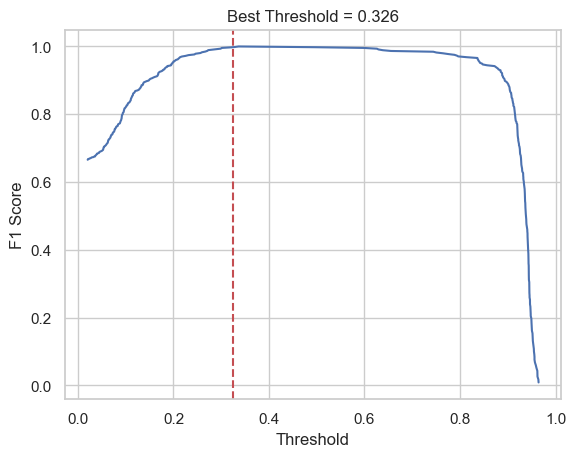

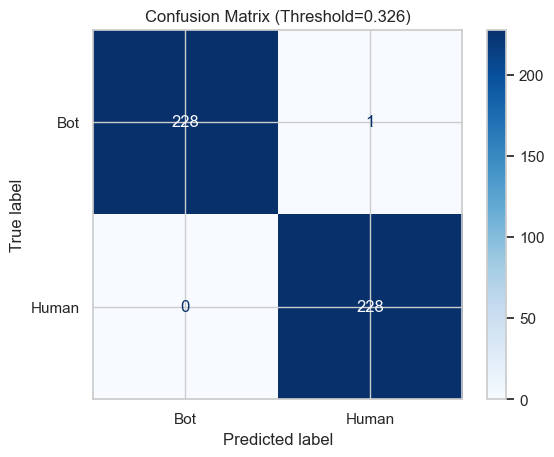

True Negatives: 228
False Positives: 1
False Negatives: 0
True Positives: 228


In [60]:
# === Plots ===
plot_threshold(metrics_tf_idf["thr"], metrics_tf_idf["best_thr"], metrics_tf_idf["f1s"])
plot_confusion(y_test, metrics_tf_idf["y_pred"], metrics_tf_idf["best_thr"])

In [62]:
#View data
base_cols = ['user_id', 'label'] + (['dataset'] if 'dataset' in df.columns else [])
data = df[base_cols].merge(user_docs, on='user_id', how='inner').copy()

# Binary label
data['y'] = data['label'].astype(str).str.lower().map({'bot':1}).fillna(0).astype(int)


print("\nExample bot doc:\n", data.loc[data['y']==1, 'text_joined'].iloc[0][:900])
print("\nExample human doc:\n", data.loc[data['y']==0, 'text_joined'].iloc[0][:900])




Example bot doc:
 RT @CryptnomicsOrg: #Latest: MetaMask Denies $10 Million Wallet Hack Was MetaMask Exploit https://t.co/2qSAfw4Z7W RT @CryptoCapo_: Still short and strong. RT @GlobalEconNews: #Latest: How An Unemployed Trader Became a $700 Million Exile https://t.co/wEm7znsq1k RT @kucoincom: 🔥 Get ready for the ETH 2.0 Staking and withdrawal function on @KuCoin_Earn! Starting 14:30:00 on April 18, 2023 (UTC), user… @LocalFox8 Possible sad neutral response: "It's always tough to deal with health issues, and liver disease can be p… https://t.co/gYrJbl288A @brian_armstrong @FrancescaH75050 @griffitha Whatever. https://t.co/WJM5wf5xwd #Breaking: The Promise and Threat of China’s Smart Cities https://t.co/oymEpjgNKw RT @Bitboy_Crypto: People talk so much smack about me but they just keep talking 😂

You only get a few clout chasing chances and some of y’… RT @saylor: #Bitcoin is a swarm of cyber hornets servin

Example human doc:
 @christophkoeck In Diskussionen in D erlebe ich eine starke